<a href="https://colab.research.google.com/github/AnshUpadhyay639/Skin-Cancer-Detection/blob/main/Skin_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import needed libraries

In [219]:
# import system libs
import os
import time
import shutil
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


### Read data

In [240]:
import pandas as pd
data = pd.read_csv('hmnist_28_28_RGB.csv') # Downloaded from https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000?select=hmnist_28_28_RGB.csv
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


# **Data Preprocessing**

### Split data and labels

In [221]:
Label = data["label"]
Data = data.drop(columns=["label"])
Data.shape

(10015, 2352)

### Handling imbalanced datasets

In [222]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [223]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

### Convert abbreviations to it's words

In [224]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'),
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

### Splitting train and test

In [225]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 42)

In [226]:
print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}\ny_test shape: {y_test.shape}')

X_train shape: (35201, 28, 28, 3)
X_test shape: (11734, 28, 28, 3)
y_train shape: (35201,)
y_test shape: (11734,)


### Convert labels to categorical types

In [227]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
y_train.shape

(35201, 7)

### Create Image Data Generation

In [228]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1)

testgen = ImageDataGenerator(rescale=(1./255))

### Create ReduceLROnPlateau to learning rate reduction

In [229]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.0001)

# Model Structure

In [230]:
import keras
from keras.optimizers import Adamax

model = keras.models.Sequential()

# Input Layer
model.add(keras.layers.Input(shape=[28, 28, 3]))

# Convolutional Layers (Same as before)
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())

# Flatten Layer
model.add(keras.layers.Flatten())

# **Only One Fully Connected Layer**
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

# Compile Model (No Change)
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_160 (Conv2D)                  │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_94 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_149              │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_161 (Conv2D)                  │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_162 (Conv2D)                  │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_95 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_150              │ (None, 7, 7, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_163 (Conv2D)                  │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_164 (Conv2D)                  │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_96 (MaxPooling2D)      │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_151              │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_165 (Conv2D)                  │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_166 (Conv2D)                  │ (None, 3, 3, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_97 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classifier (Dense)                   │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,165,703 (4.45 MB)

 Trainable params: 1,165,255 (4.45 MB)

 Non-trainable params: 448 (1.75 KB)

### Training model

In [231]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=15 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])

Epoch 1/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.6164 - loss: 1.1774 - val_accuracy: 0.8758 - val_loss: 0.4266 - learning_rate: 0.0010
Epoch 2/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9242 - loss: 0.2401 - val_accuracy: 0.9603 - val_loss: 0.1441 - learning_rate: 0.0010
Epoch 3/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9666 - loss: 0.1193 - val_accuracy: 0.9651 - val_loss: 0.1115 - learning_rate: 0.0010
Epoch 4/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9775 - loss: 0.0851 - val_accuracy: 0.9696 - val_loss: 0.0977 - learning_rate: 0.0010
Epoch 5/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9867 - loss: 0.0526 - val_accuracy: 0.9790 - val_loss: 0.0701 - learning_rate: 0.0010
Epoch 6/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9931 - loss: 0.0325 - val_accuracy: 0.9857 - val_loss: 0.0617 - learning_rate: 0.0010
Epoch 7/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9885 - loss: 0

### Show training history

In [232]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

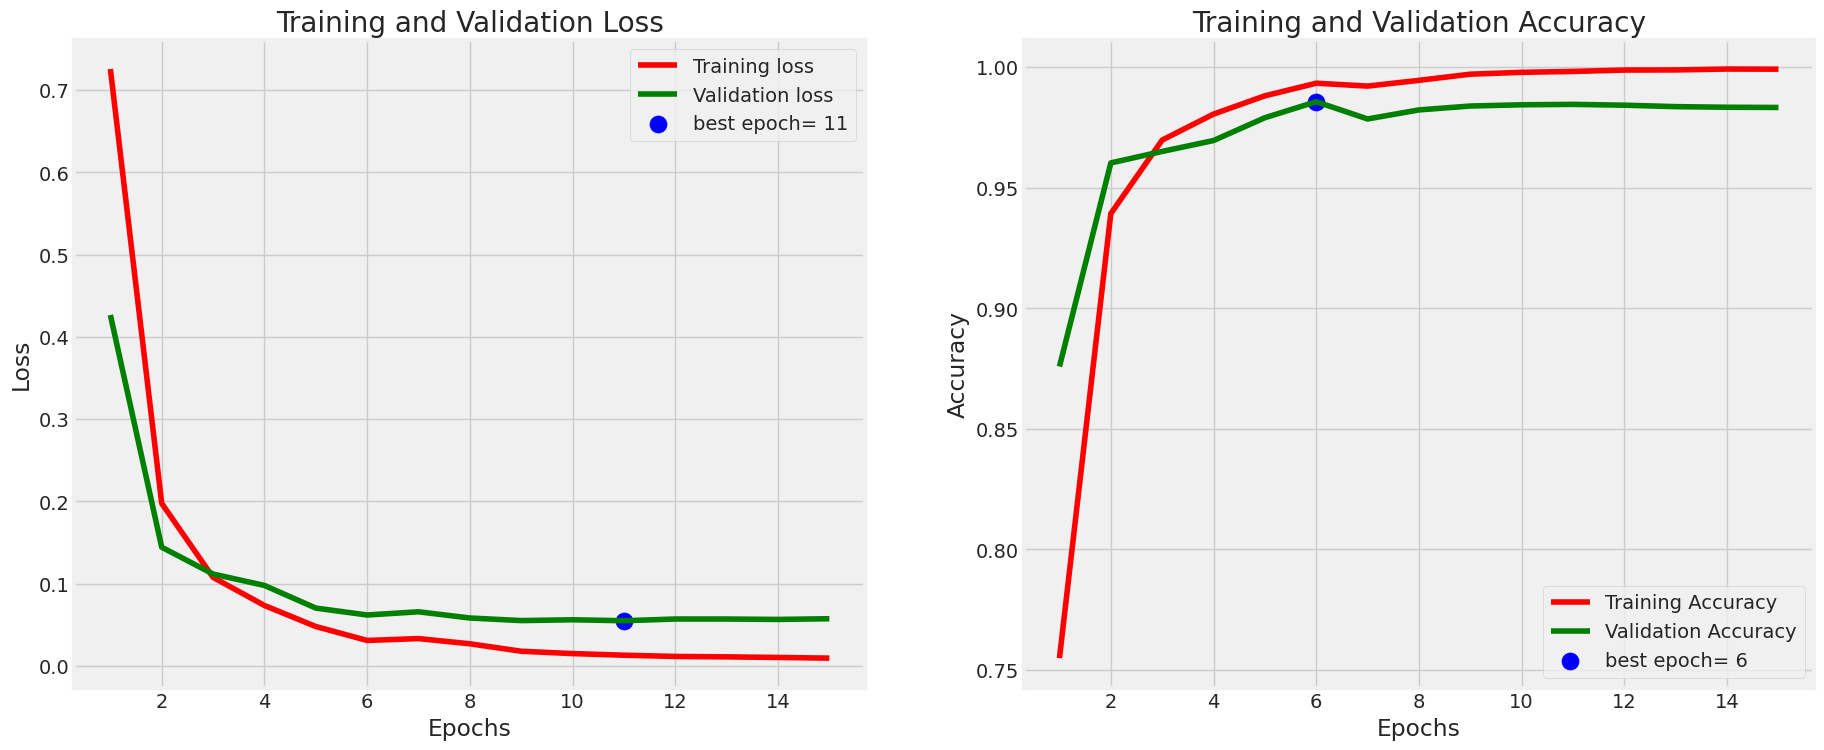

In [233]:
plot_training(history)

# Model Evaluation

In [234]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1101/1101 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 1.0000 - loss: 0.0034
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9831 - loss: 0.0551
Train Loss:  0.003325616242364049
Train Accuracy:  0.999943196773529
--------------------
Test Loss:  0.057176265865564346
Test Accuracy:  0.9832963943481445


In [235]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


### Create classes labels

In [236]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


### Confussion Matrix

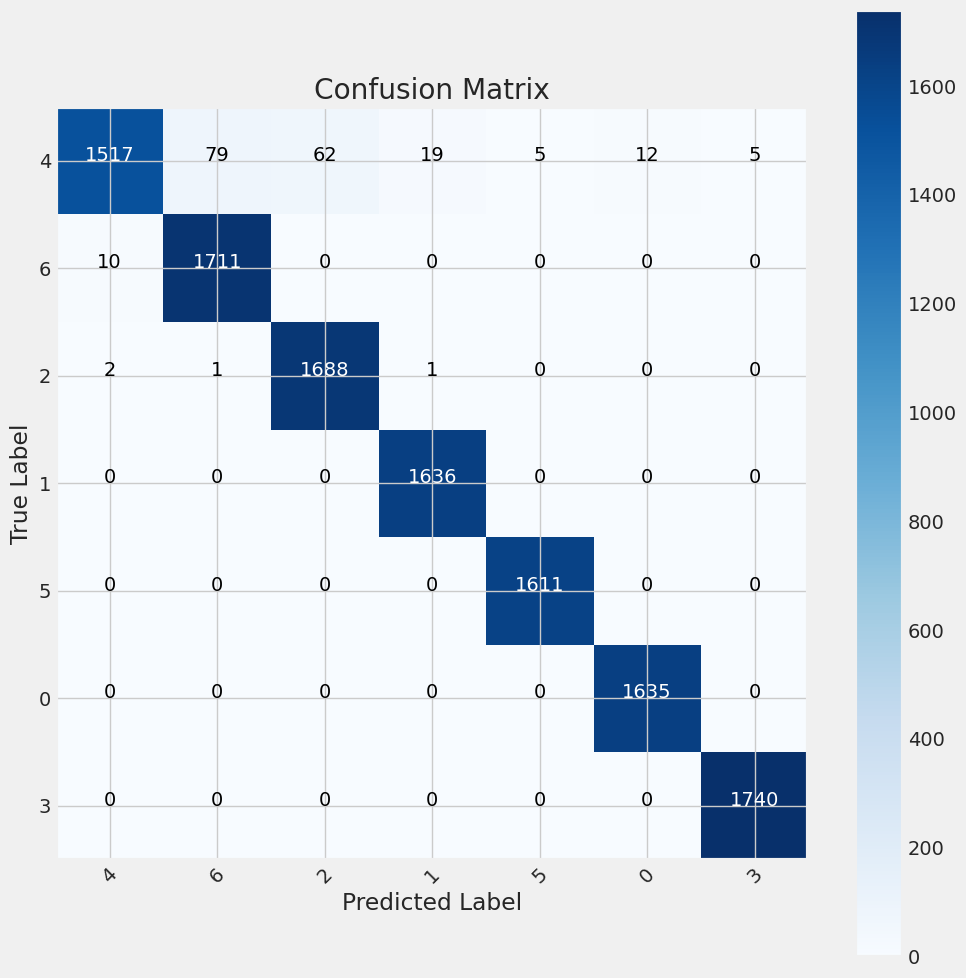

In [237]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=classes_labels)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

### Save model

In [241]:
#Save the model
model.save('Skin Cancer.keras')